## Imports

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import operator
import random
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
import itertools

%matplotlib inline 

## Graph Creation

In [2]:
facebook = nx.Graph()

## Read dataset, Draw the Graph

In [3]:
def open_source_file(filename):
    with open (filename,"r") as file:
        if filename == "../data/facebook-links.txt":
            content = file.readlines()
            for i in range(len(content)):
                point1 = content[i].split("\t")[0]
                if point1 not in facebook:
                    facebook.add_node(point1)
                point2 = content[i].split("\t")[1]
                if point2 not in facebook:
                    facebook.add_node(point2)
                facebook.add_edge(point1,point2)
        else:
            print ("Not a valid file, please check again")

In [4]:
open_source_file("../data/facebook-links.txt")

## Show the basic info about the Facebook Graph

In [5]:
def show_basic_info(graph):
    print (nx.info(graph))

In [6]:
print ("Original Dataset")
show_basic_info(facebook)

Original Dataset
Name: 
Type: Graph
Number of nodes: 63731
Number of edges: 817090
Average degree:  25.6418


## Remove the user only have one friend

In [7]:
# only do it once!!!!
def remove_user_with_one_friend(graph):
    edge_to_remove = {}
    # find the user with only one friend, and store the edge connection as a dictionary format.
    # the format of dictionary is: {user(shown in user_id): the only friend(shown in user_id)}
    for node in nx.nodes_iter(graph):
        if (len(graph.neighbors(node)) <= 1):
            neighbor = graph.neighbors(node)
            edge_to_remove[node] = neighbor[0]
        else:
            pass
    
    first10pairs = {k: edge_to_remove[k] for k in list(edge_to_remove)[:10]}
    print ("First 10 pairs",first10pairs)
        
    for key in edge_to_remove:
        if graph.has_edge(key,edge_to_remove[key]):
            graph.remove_edge(key,edge_to_remove[key])
        else:
            pass
        if graph.has_node(key):
            graph.remove_node(key)
        else:
            pass
    # after removing,there are some nodes that don't have edges.We simply delete those nodes as well. 
    further_node_to_remove = []
    for node in nx.nodes_iter(graph):
        if (len(graph.neighbors(node)) == 0):
            further_node_to_remove.append(node)
    print ("After preliminary removing, further remove users with no friends",further_node_to_remove)
    for node in further_node_to_remove:
        graph.remove_node(node)

In [8]:
# remove_user_with_one_friend(facebook)

In [9]:
print ("Dataset after removing")
show_basic_info(facebook)

Dataset after removing
Name: 
Type: Graph
Number of nodes: 63731
Number of edges: 817090
Average degree:  25.6418


## Adjacency Matrix

In [10]:
adjacency_matrix = {}
for node in nx.nodes_iter(facebook):
    adjacency_matrix[int(node)] = [neighbor for neighbor in nx.all_neighbors(facebook,node)]   
# print the first 10 users with their friends for testing purposes
for i in range(5):
    print ("adjacency_matrix",[i+1],":",adjacency_matrix[i+1])

adjacency_matrix [1] : ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27']
adjacency_matrix [2] : ['1', '1132', '3', '2053', '2054', '479', '51', '2055', '7', '9', '1645', '11', '12', '2056', '16', '17', '18', '2057', '1237', '23', '2058', '53', '2059', '2060', '1079', '2061']
adjacency_matrix [3] : ['1', '1747', '2', '2599', '1638', '1199', '2600', '683', '1289', '2055', '6', '7', '2958', '1645', '11', '12', '2056', '1649', '309', '15', '16', '17', '18', '19', '30605', '1003', '17297', '15818', '1237', '42296', '821', '53', '4223', '2059']
adjacency_matrix [4] : ['1', '2888', '2636', '2638', '2174', '2957', '2958', '2175', '2959', '2960']
adjacency_matrix [5] : ['1', '813', '1636', '814', '1640', '4503', '1641', '1642', '683', '2054', '4964', '1643', '1644', '639', '2957', '4219', '2056', '687', '815', '1646', '1648', '1649', '1650', '4246', '22', '1095', '12366', '821', '469', '2548', '27

## Create Dictionary, for number of friends

In [11]:
num_of_friends = {}
for key in adjacency_matrix:
    num_of_friends[int(key)] = len(adjacency_matrix[key])

In [12]:
updat_num_of_friends = sorted(num_of_friends.items(), key=lambda x: (-x[1], x[0]))

In [13]:
num_users = len(adjacency_matrix)
print ("number of users in total:",num_users)

number of users in total: 63731


## Calculate the sparisty of dataset

In [14]:
utility = np.zeros((num_users, num_users))
for user_id, user_friend_ids in adjacency_matrix.items():
    for x in user_friend_ids:
        utility[(int)(user_id) - 1, (int)(x) - 1] = 1
        
sparsity = float(len(utility.nonzero()[0]))
sparsity /= (utility.shape[0] * utility.shape[1])
sparsity *= 100
print('Sparsity: {:.2f}%'.format(sparsity))
utility = utility[0:20000,0:20000]

Sparsity: 0.04%


## Evaluation via Mean Squared Error (MSE)

In [15]:
def mse_utility(u1, u2):
    return mse(u1[u1.nonzero()].flatten(), u2[u2.nonzero()].flatten())

## Similarity via Cosine Distance

In [16]:
def cosine_sim(v1, v2):
    numerator = sum([x * y for x, y in zip(v1, v2)])
    denominator = np.sqrt(sum([x ** 2 for x in v1])) * np.sqrt(sum([x ** 2 for x in v2]))
    return numerator / denominator

In [17]:
def sim_matrix(u, eps=1.0e-9):
    step1 = u.dot(u.T) + eps
    step2 = np.array([np.sqrt(np.diagonal(step1))])
    return (step1 / step2 / step2.T)

In [18]:
%timeit -n 10 -r 3 sim_matrix(utility[:50,:])

The slowest run took 4.30 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 9.67 ms per loop


In [19]:
def sim_users(u):
    return sim_matrix(u)

print(sim_users(utility[:50,:50]))

[[  1.00000000e+00   5.58156306e-01   5.91312396e-01 ...,   7.41249317e-02
    1.96116135e-10   2.77350098e-01]
 [  5.58156306e-01   1.00000000e+00   6.67423813e-01 ...,   1.19522861e-01
    3.16227766e-10   2.23606798e-01]
 [  5.91312396e-01   6.67423813e-01   1.00000000e+00 ...,   1.13960576e-10
    3.01511344e-10   2.13200717e-01]
 ..., 
 [  7.41249317e-02   1.19522861e-01   1.13960576e-10 ...,   1.00000000e+00
    3.77964473e-01   2.67261242e-10]
 [  1.96116135e-10   3.16227766e-10   3.01511344e-10 ...,   3.77964473e-01
    1.00000000e+00   7.07106781e-10]
 [  2.77350098e-01   2.23606798e-01   2.13200717e-01 ...,   2.67261242e-10
    7.07106781e-10   1.00000000e+00]]


# K neighborhood

In [20]:
def top_k(arr, self_idx, k):
    val_index = { v:key for key, v in enumerate(arr) }
    top_k_val = sorted(val_index.keys())[::-1]
    i = 0
    res = {}
    while i < k:
        if val_index[top_k_val[i]] == self_idx:
            i += 1
            k += 1
            continue
        res[val_index[top_k_val[i]]] = top_k_val[i]
        i += 1
    return res

## Recommend via Similar Users

In [21]:
def rec_via_users(m_utility, m_sim_users, user_idx, frd_idx, k):
    items = m_utility[:, frd_idx]
    i_sim = top_k(m_sim_users[:, user_idx], user_idx, k)
    non_zero_index = [i for i in i_sim if items[i] != 0]
    if sum([i_sim[i] for i in non_zero_index]) == 0:
        return 0
    return sum([i_sim[i] * items[i] for i in non_zero_index]) / sum([i_sim[i] for i in non_zero_index])

## Evaluation

In [22]:
random.seed(12345)

def recs_via_users(m_utility, m_sim_users, k, test_n):
    test = random.sample(range(m_sim_users.shape[0]), test_n)
    true = []
    pred = []
    for user_idx in test:
        for item_idx in range(m_utility.shape[1]):
            if m_utility[user_idx][item_idx] != 0:
                true.append(m_utility[user_idx][item_idx])
                
                p = round(rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k))
                if p != 0:    
                    pred.append(p)
                else:
                    pred.append(1.0e-9)
                        

    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))
    
similarity_users = sim_users(utility)

ks = []
mses = []
for i in range(50):
    ks.append(i+1)
    mses.append(recs_via_users(utility, similarity_users, i+1, 100))
    print("{}/50".format(i+1), mses[-1])

1/50 0.602441358297
2/50 0.486766120297
3/50 0.401515150712
4/50 0.37957665828
5/50 0.352803737612
6/50 0.352233216733
7/50 0.309199521484
8/50 0.265583553845
9/50 0.279977050501
10/50 0.268702717311
11/50 0.279517379504
12/50 0.291489361119
13/50 0.270888070924
14/50 0.250399232971
15/50 0.223288381296
16/50 0.217059638956
17/50 0.209167391517
18/50 0.192296718588
19/50 0.184735706211
20/50 0.194568579879
21/50 0.20403749058
22/50 0.164860095461
23/50 0.174589699707
24/50 0.192241378926
25/50 0.153157759857
26/50 0.159187385976
27/50 0.113636363409
28/50 0.142202940183
29/50 0.136625264798
30/50 0.129756364372
31/50 0.15365239264
32/50 0.13223371514
33/50 0.139067730858
34/50 0.147500682579
35/50 0.110539845537
36/50 0.119988293585
37/50 0.129688493065
38/50 0.134956416923
39/50 0.137373737099
40/50 0.108219177866
41/50 0.0832345969899
42/50 0.125449101546
43/50 0.0891405340842
44/50 0.174208144448
45/50 0.111563044518
46/50 0.0798305635419
47/50 0.0906219628897
48/50 0.0916417908615


In [23]:
# %timeit -n 10 -r 3 recs_via_users(utility, similarity_users, 2, 100)

In [24]:
# %timeit -n 10 -r 3 recs_via_users(utility, similarity_users, 20, 100)

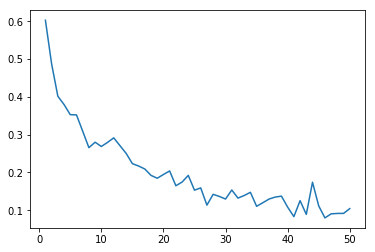

In [26]:
plt.plot(ks, mses)